In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from sklearn.model_selection import train_test_split
import scripts.plotting as pl
import scripts.utils as ut
import anndata

C:\Users\yyyyx\miniconda3\envs\sc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read_10x_mtx('./Data/Single-cell_raw_data/')

In [29]:
meta = pd.read_csv('./Data/GSM8538852_20221110_OC43_HEK_5p_2_cellIDs.csv', sep='\t')

In [5]:
meta_dict = meta.set_index("cell_barcode")["condition"].to_dict()

adata.obs["condition"] = adata.obs.index.map(meta_dict)

In [6]:
adata.layers['counts'] = adata.X.copy()

In [8]:
adata = ut.add_qc_metrics(adata)
adata = ut.basic_qc_filter(adata, pct_mt_max=20.0)
adata = ut.normalize_log1p(adata)

QC metrics added. Viral counts detected in 18944 cells.
✅ Filtering complete. Remaining cells: 12980, Genes: 21640
Normalization (target_sum=10000.0) and log1p transformation applied.


In [9]:
adata

AnnData object with n_obs × n_vars = 12980 × 21640
    obs: 'condition', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_oc43', 'pct_counts_oc43', 'viral_fraction', 'viral_per_10k', 'y_log1p_per10k', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'oc43', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [11]:
anndata.settings.allow_write_nullable_strings = True
adata.write_h5ad('./Data/h5ad/Oc43_adata.h5ad')

In [12]:
HELD_OUT_CONDITION = None
TEST_SIZE = 0.2
RANDOM_STATE = 4
INFECTED_ONLY = True

C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning\scripts\plotting.py:997: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 1, 1]) # Make room for y-label


Split-axis histogram saved to: ./Plot/oc43_split_hist


(<Figure size 1800x1200 with 2 Axes>,
 (<Axes: >, <Axes: xlabel='Total counts (OC43)'>))

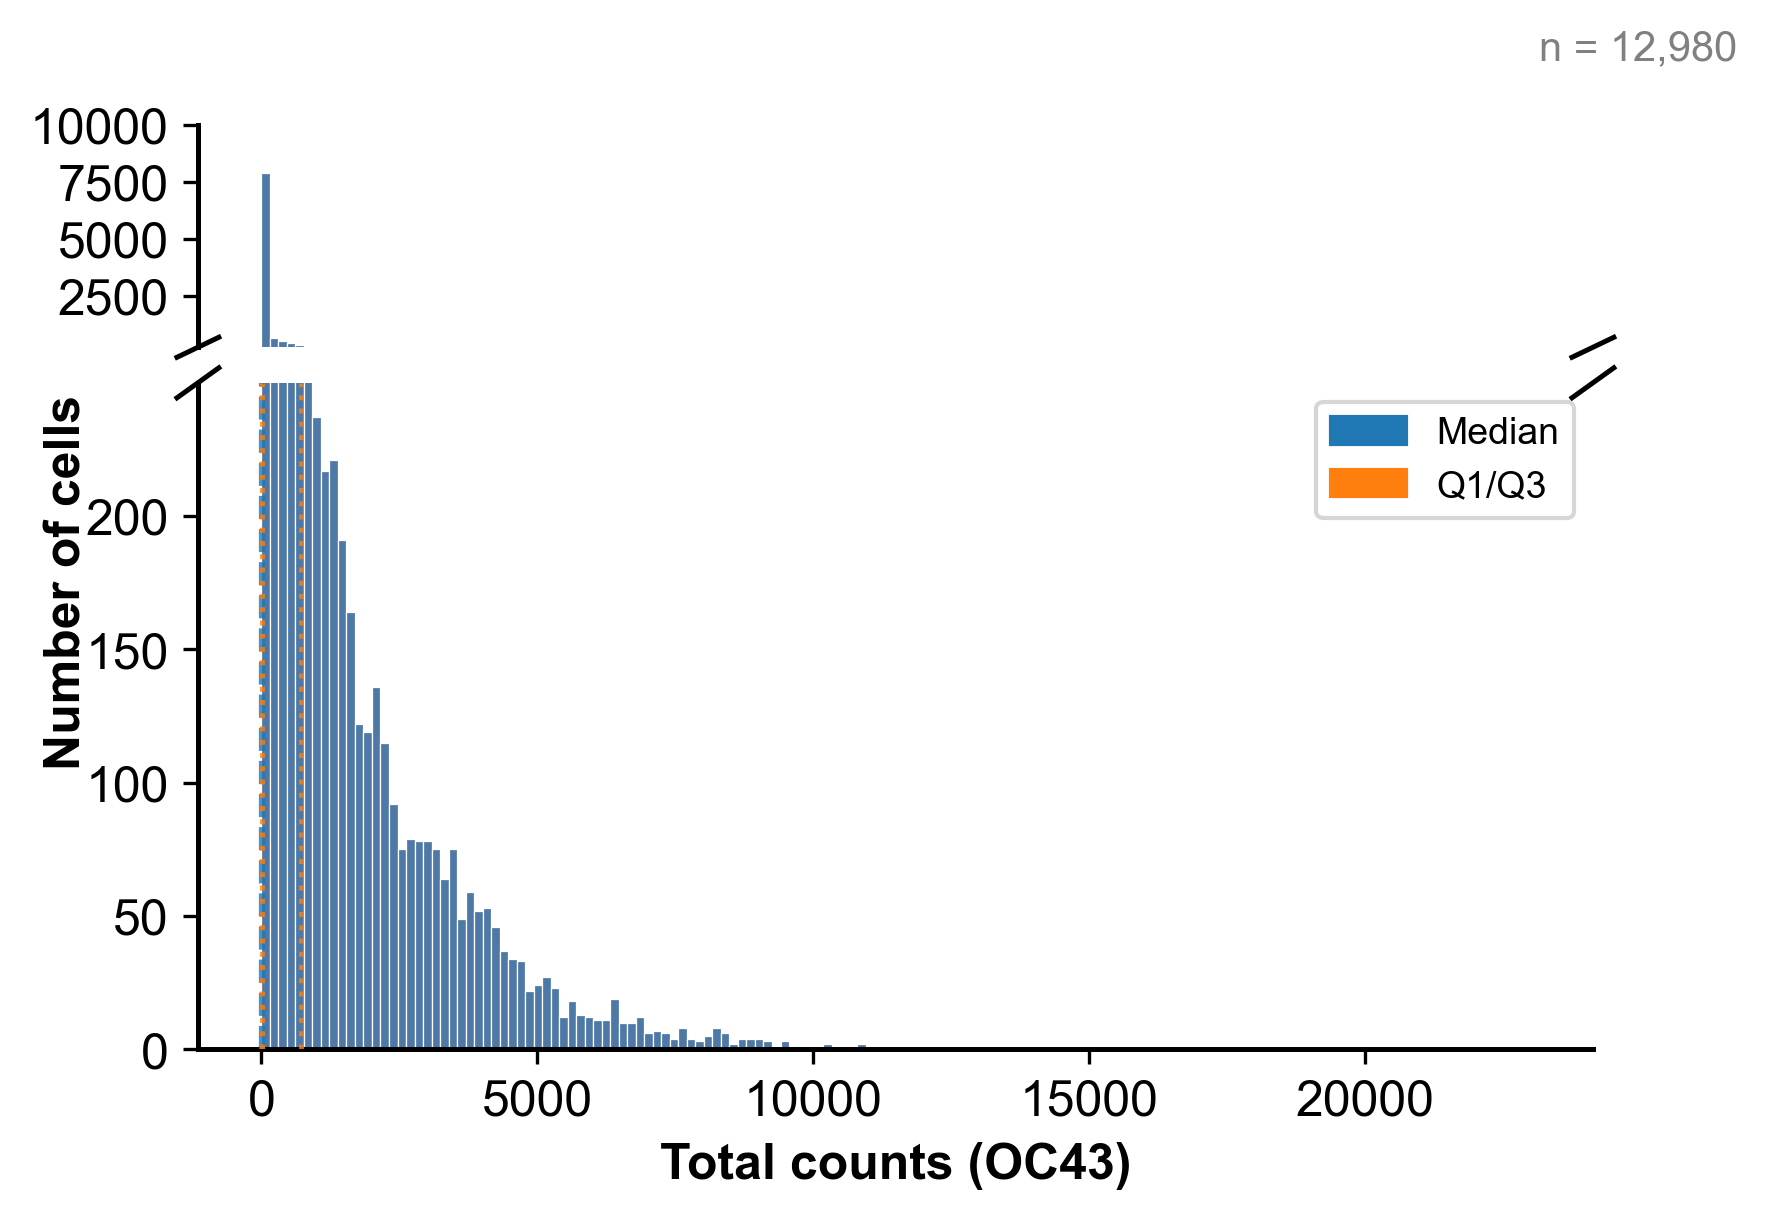

In [13]:
pl.set_publication_style()

counts_oc43 = adata.obs['total_counts_oc43'].values

pl.plot_split_axis_histogram(
    data=counts_oc43,
    threshold_split=250,
    xlabel='Total counts (OC43)',
    save_path='./Plot/oc43_split_hist'
)

In [14]:
if INFECTED_ONLY:
    if 'pct_counts_oc43' not in adata.obs.columns:
        raise ValueError("adata.obs['pct_counts_oc43'] is needed.")
    infected_mask = ((adata.obs['pct_counts_oc43'] > 0.1) & (adata.obs['total_counts_oc43'] > 10))
    adata = adata[infected_mask].copy()

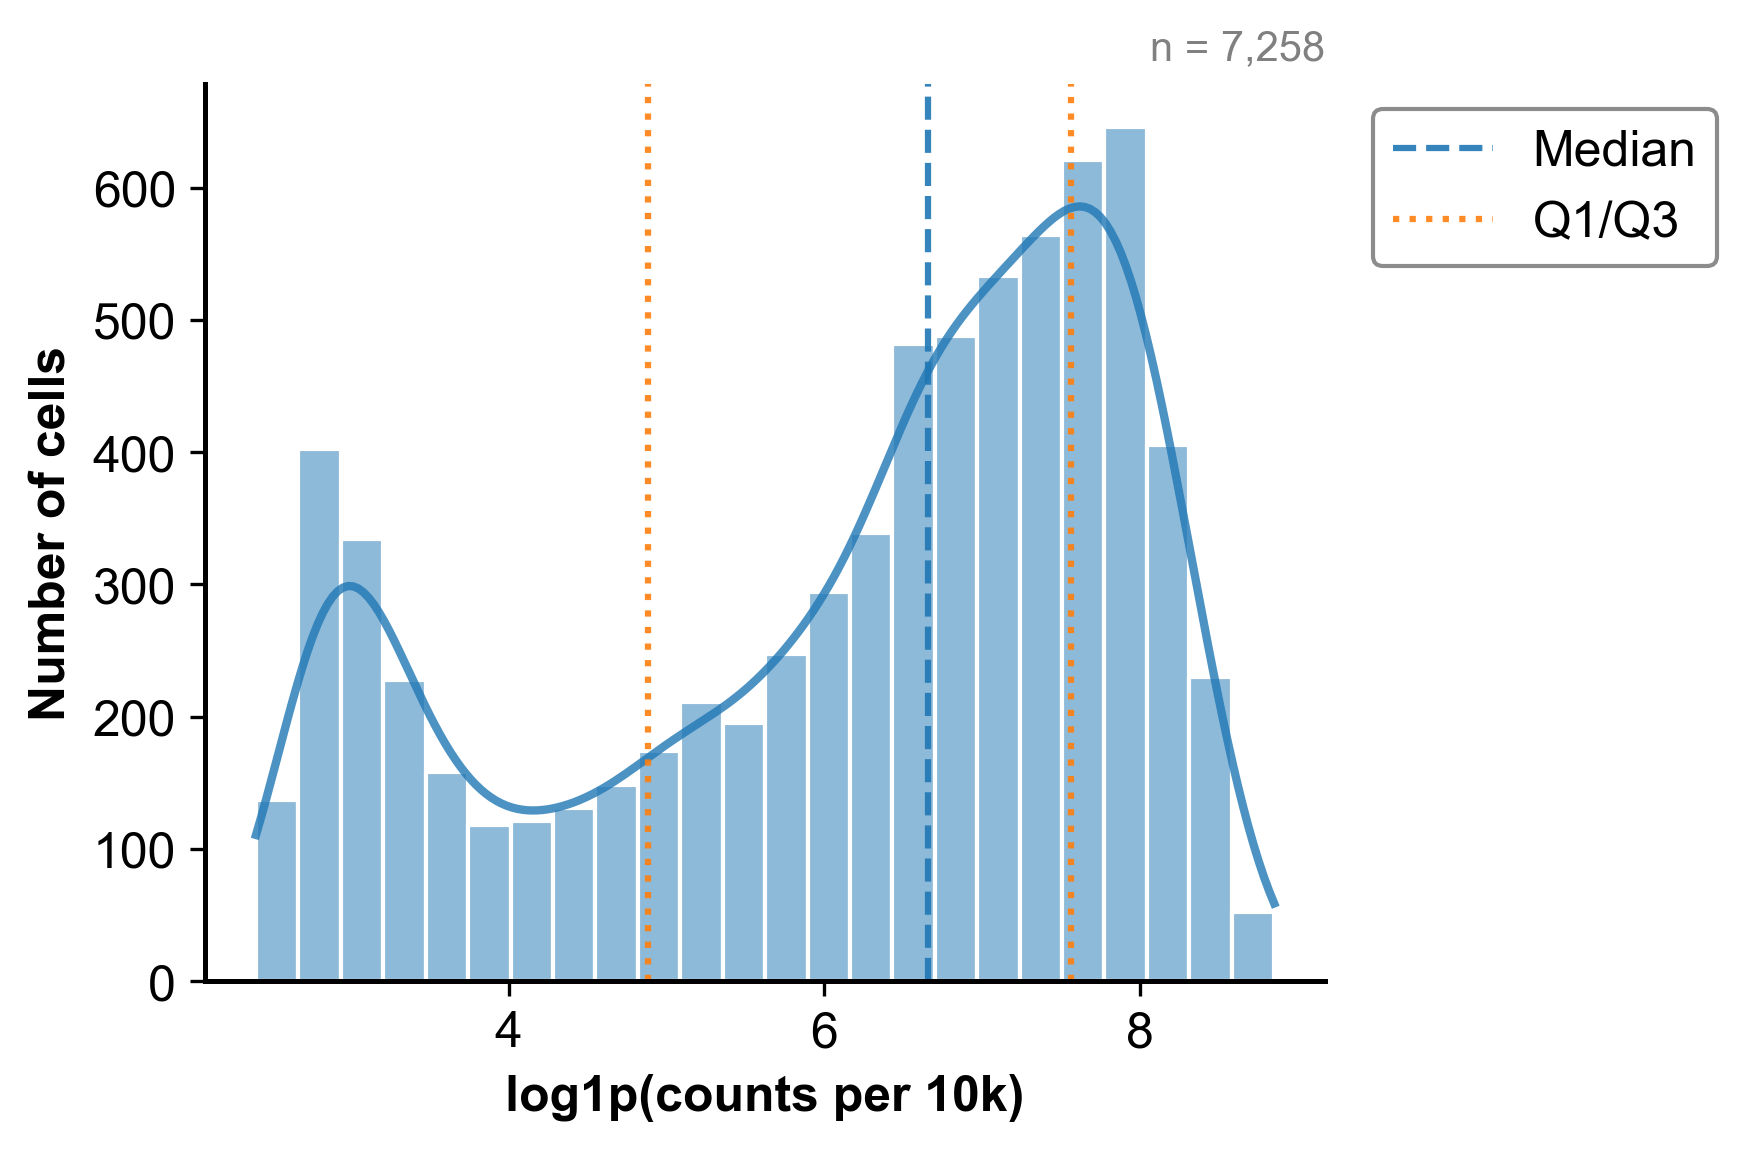

In [15]:
x2 = adata.obs['y_log1p_per10k'].to_numpy()

fig, ax = pl.plot_distribution_hist(
    data=x2,
    xlabel="log1p(counts per 10k)",
    title=f"n = {len(x2[np.isfinite(x2)]):,}",
    save_path="./Plot/log1p_hist_distribution"
)

In [16]:
if HELD_OUT_CONDITION is not None:
    assert 'condition' in adata.obs.columns, "adata.obs['condition'] is needed."
    train = adata[adata.obs['condition'] != HELD_OUT_CONDITION].copy()
    test  = adata[adata.obs['condition'] == HELD_OUT_CONDITION].copy()
else:
    assert 'condition' in adata.obs.columns, "adata.obs['condition'] is needed."
    idx_train, idx_test = [], []
    for cond, idx in adata.obs.groupby('condition').indices.items():
        tr, te = train_test_split(list(idx), test_size=TEST_SIZE, random_state=RANDOM_STATE)
        idx_train.extend(tr); idx_test.extend(te)
    train = adata[idx_train].copy()
    test  = adata[idx_test].copy()


In [17]:
sc.pp.highly_variable_genes(train,flavor='seurat', subset=False, inplace=True)
hvgs = train.var_names[train.var['highly_variable']]

In [18]:
host_train = train.var_names[~train.var['oc43']]
host_test  =  test.var_names[~test.var['oc43']]

cols = host_train.intersection(hvgs).intersection(host_test)
train_sub = train[:, cols].copy()
test_sub  =  test[:, cols].copy()

In [19]:
host_train = train.var_names[~train.var['oc43']]
host_test  =  test.var_names[~test.var['oc43']]
cols = host_train.intersection(hvgs).intersection(host_test)

train_sub = train[:, cols].copy()
test_sub  =  test[:, cols].copy()

feature_names = cols.to_list()

In [20]:
scaler = StandardScaler(with_mean=True)

Xtr = train_sub.X.toarray() if sp.issparse(train_sub.X) else np.asarray(train_sub.X)
Xte = test_sub.X.toarray()  if sp.issparse(test_sub.X)  else np.asarray(test_sub.X)

X_train = scaler.fit_transform(Xtr)
X_test  = scaler.transform(Xte)

In [21]:
y_train = train.obs['y_log1p_per10k'].copy()
y_test  =  test.obs['y_log1p_per10k'].copy()

In [22]:
scaler = StandardScaler(with_mean=False)

Xtr_raw = train_sub.X.toarray() if sp.issparse(train_sub.X) else np.asarray(train_sub.X)
Xte_raw = test_sub.X.toarray()  if sp.issparse(test_sub.X)  else np.asarray(test_sub.X)

scaler = StandardScaler(with_mean=True)
X_train = scaler.fit_transform(Xtr_raw)
X_test  = scaler.transform(Xte_raw)

train_df = pd.DataFrame(X_train, index=train_sub.obs_names, columns=feature_names)
train_df['target'] = pd.Series(y_train, index=train_sub.obs_names, dtype=float)

test_df  = pd.DataFrame(X_test,  index=test_sub.obs_names,  columns=feature_names)
test_df['target']  = pd.Series(y_test,  index=test_sub.obs_names, dtype=float)

print(train_df.shape, test_df.shape)
print("train_df columns (first 5):", train_df.columns[:5].tolist())
print("target head:", train_df['target'].head())

(5805, 1615) (1453, 1615)
train_df columns (first 5): ['SAMD11', 'HES4', 'CPTP', 'MXRA8', 'CCNL2']
target head: CGAGCACCATGAAGTA-1    2.671000
TTCTTAGTCGTCTGAA-1    4.407447
GAGGTGAAGTCTCCTC-1    2.776021
ACGGGCTAGACCACGA-1    2.753577
TCGCGAGCAGGTTTCA-1    3.193407
Name: target, dtype: float64


In [23]:
train_df.to_csv('./CSV/train_df.csv', index=False)
test_df.to_csv('./CSV/test_df.csv', index=False)

In [24]:
test_sub.write_h5ad('./Data/h5ad/test.h5ad')
train_sub.write_h5ad('./Data/h5ad/train.h5ad')

In [25]:
import session_info

session_info.show()